# Protein LM Embeddings and Logits as Features

One of the best ways you can leverage a large language model is for feature generation. The internal, numeric representations the neural-net uses to make predictions can be output and used for downstream machine learning tasks. The numeric vectors from NLP models often encode additional, powerful information beyond simple one-hot encodings. Usually feature engineering for biology is heavily task-specific, but in this case the embeddings can be used for a variety of classification, regression, and other tasks.

On the backend, the process involves passing input sequences into the pre-trained model for tokenization and representation of the protein through its neural-net layers. Multiple representations of a protein - numeric vectors and/or matrices, such as attention maps - are created. Here we will quickly demo using ESM2 via GPU-backed REST API in order to quickly transform a sequence into embeddings without installing packages, setting up a GPU, and downloading the model.

## Get and set your API Token

To use the BioLM API, you need an API token. You can get one from the [User API Tokens](https://biolm.ai/ui/accounts/user-api-tokens/) page.

Paste the API token in the cell below, as the value of the variable `BIOLMAI_TOKEN`.

In [1]:
BIOLMAI_TOKEN = " "  # !!! YOUR API TOKEN HERE !!!

In [14]:
from IPython.display import JSON  # Helpful UI for JSON display

try:
    # Install packages to make API requests in JLite
    import micropip
    await micropip.install('requests')
    await micropip.install('pyodide-http')
    await micropip.install('pandas')
    await micropip.install('xgboost')
    await micropip.install('scikit-learn')
    await micropip.install('matplotlib')
    await micropip.install('seaborn')
    # Patch requests for in-browser support
    import pyodide_http
    pyodide_http.patch_all()
except ModuleNotFoundError:
    pass  # Won't be using micropip outside of JLite

import requests  # Will use to make calls to BioLM.ai
import os
import pandas as pd
from glob import glob

In [47]:
import json
import asyncio
import random

In [46]:
import seaborn as sns
import xgboost as xgb
from sklearn import model_selection
from matplotlib import pyplot as plt

In [4]:
# Load sequences and fluorescence data
df = pd.concat([
    pd.read_csv(f) for f in
    glob(os.path.join('.', 'data', 'protein', 'data', 'fluor*.train.csv'))
])

df.drop_duplicates('seq', inplace=True)

In [5]:
df.shape

(21446, 2)

In [7]:
# SAMPLE some of the data
df_orig = df  # Retain original DF as `df_orig`
df = df_orig.copy().sample(50, random_state=42)

df.head(6)

seq     label
11216  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  1.301721
2189   SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.625562
408    SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.781927
14440  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.359145
8116   SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDSTYGKLTLKFI...  3.636357
6067   SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  2.903396

Here we have a DataFrame containing sequences and their measured fluorescence. We can use the ESM2 embeddings as features to perform a quick regression to predict fluorescence values; but first we need to actually generate the embeddings.

Let's write a function that takes a sequence and requests its embeddings via REST API. The [ESM2 encode endpoint documentation](https://api.biolm.ai/#daa50ec7-0da2-4bff-ab4c-3ead7f377154) provides examples of the structure of a response.

In [8]:
SLUG = 'esm2-650m'
ACTION = 'encode'

## Single Sequence Embeddings

In [9]:
test_protein = df.sample(1).seq.iloc[0]

print("Sequence length: {}\n{}".format(len(test_protein), test_protein))

Sequence length: 237
SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHELEYNYNSHNVYIMADKQKNGIKVNFKIRHNTEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


In [15]:
async def requests_post(model_slug, action, data, api_token):  # async function for requests
    action = action.strip().lower()
    model_slug = model_slug.strip()
    api_token = api_token.strip()
    assert isinstance(data, dict)
    data_str = json.dumps(data)

    resp = requests.post(
        f"https://biolm.ai/api/v2/{model_slug}/{action}/",
        data=data_str,
        headers={
            "Content-Type": "application/json",
            "Authorization": f"Token {api_token}",
        },
    )

    json_resp = resp.json()
    return json_resp

We can POST that sequence:

In [16]:
# Definition comes from API reference docs linked just above
data = {
        "params": {
            "include": [
                "mean",
                "contacts",
                "logits",
                "attentions"
            ]
    },
  "items": [
    {
      "sequence": test_protein
    }
  ]
}


# Async function to get embeddings via REST API
response = await requests_post(SLUG, ACTION, data, BIOLMAI_TOKEN)

In [17]:
from IPython.display import JSON

JSON(response)

<IPython.core.display.JSON object>

We get back a list of dicts. Each dictionary item `mean_representations` contains the mean representations of a layer(s) from ESM2. In this case, we return the embeddings from the the final hidden layer, `33`.

Let's load this representation and look at its shape.

In [19]:
embed_single = pd.DataFrame(response['results'][0]['mean_representations']['33']).T

embed_single

0        1         2         3         4         5         6     \
0 -0.007789 -0.00575 -0.053668 -0.005007 -0.098041 -0.014409 -0.038005   

       7         8         9     ...      1270      1271      1272      1273  \
0  0.011166  0.067107 -0.083323  ...  0.148685  0.068716  0.010204  0.089825   

       1274      1275      1276      1277      1278      1279  
0 -0.022044  0.107525  0.078175  0.005698 -0.016077 -0.028578  

[1 rows x 1280 columns]

We can see that while the original sequence is `237` residues, the LLM uses a vector of `1280` to represent sequences. So, anytime we request an embedding for a sequence, we'll get back a representation that is the same size as another sequence. This makes downstream ML, especially with other NNs, nice and easy since we don't have to worry about padding.

Let's get the embeddings for all sequences in the DF, asynchronously, via REST API.

## Embeddings for All Seqs in DF

In [20]:
# Limit concurrency to 3 requests at a time (*not* RPS)
sem = asyncio.Semaphore(5)


results = []

async def f(seq):
    # Add small jitter
    jitter = random.randint(1, 100) / 100.0  
    await asyncio.sleep(jitter * 4)
    # Definition comes from API reference docs linked just above
    data = {
        "params": {
            "include": [
                "mean",
                "contacts",
                "logits",
                "attentions"
            ]
        },
        "items": [
        {
          "sequence": seq

        }
      ]
    }
    # Request the embeddings

    # Async function to get embeddings via REST API
    async with sem:
        response = await requests_post(SLUG, ACTION, data, BIOLMAI_TOKEN)
        res = response['results'][0]['mean_representations']['33']
        
    return res


ops = [f(seq) for seq in df['seq'].to_list()]
rets = await asyncio.gather(*ops)

In [21]:
len(rets)

50

Now, instead of getting the embeddings, we could have written a function to retrieve the logits. In fact, they were returned by the same API endpoint - we simply need to use a different key. We can look at the single-sequence API request we made earlier to find them:

In [25]:
logits_single = pd.DataFrame(response['results'][0]['logits']).T

logits_single

0         1         2         3         4         5         6    \
0 -5.354383 -5.719441 -5.872007 -5.698726 -5.882987 -5.850645 -5.753824   

       7         8         9    ...       227       228       229       230  \
0 -5.75289 -5.909517 -5.755636  ... -5.609401 -6.073147 -5.635273 -6.062623   

        231       232       233      234       235       236  
0 -5.684639 -5.890794 -5.841343 -5.71952 -5.475575 -5.457877  

[1 rows x 237 columns]

One could also use the sum or mean as a representation of sequence:

In [26]:
logits_single.iloc[0].sum()

-1396.3643336296082

In [27]:
logits_single.iloc[0].mean()

-5.891832631348557

## Modeling with XGBoost

In order to not require any transformations of the data, let's use a tree-based method to quickly create a regression model using these ESM2 embeddings.

We'll see how well we can model fluorescence with about 1,000 samples. With so few, we should make sure to uniformly sample our labels as much as possible.

This will take several minutes, depending on your download speed and connection bandwidth. We've added a slight jitter and limit of 5 concurrent connections above, to prevent thundering herds and overwhelming your connection. You can open your browser's Developer Tools (aka Inspector) and watch the traffic under the Network tab.

In [28]:
df_orig['bins'] = pd.cut(df_orig.label, bins=100)
df_orig['bins'] = df_orig['bins'].astype('str')

df_orig.bins.value_counts()

(3.597, 3.624]    6
(1.298, 1.327]    6
(3.65, 3.676]     4
(3.624, 3.65]     4
(3.756, 3.782]    3
(1.459, 1.486]    2
(3.703, 3.729]    2
(3.782, 3.808]    2
(3.492, 3.518]    2
(3.122, 3.148]    2
(3.729, 3.756]    2
(3.861, 3.888]    2
(3.544, 3.571]    2
(3.914, 3.94]     1
(3.175, 3.201]    1
(3.307, 3.333]    1
(2.198, 2.225]    1
(3.228, 3.254]    1
(3.465, 3.492]    1
(1.591, 1.618]    1
(3.676, 3.703]    1
(3.571, 3.597]    1
(3.333, 3.36]     1
(2.885, 2.911]    1
Name: bins, dtype: int64

In [29]:
sampled = []

df_orig = df_orig.sample(df_orig.shape[0], random_state=42)

for n, grp in df_orig.groupby('bins'):
    # At most 15 rows from each bin
    samp = grp.head(10).reset_index(drop=True)
    sampled.append(samp)
    
sampled_rows = pd.concat(sampled, axis=0).reset_index(drop=True)

df_xgboost = sampled_rows

df_xgboost.shape

(50, 3)

In [30]:
ops = [f(seq) for seq in df_xgboost['seq'].to_list()]
xgboost_embeddings = await asyncio.gather(*ops)

In [31]:
embeddings = pd.DataFrame(xgboost_embeddings)

embeddings.shape

(50, 1280)

In [33]:
# Create 80:20 train:test split
train_x, test_x, train_y, test_y = model_selection.train_test_split(
    embeddings,
    df_xgboost.label,
    test_size=0.2,
    random_state=54
)

print("X Train size: {}\nX Test size: {}".format(train_x.shape, test_x.shape))
print("Y Train size: {}\nY Test size: {}".format(train_y.shape, test_y.shape))

X Train size: (40, 1280)
X Test size: (10, 1280)
Y Train size: (40,)
Y Test size: (10,)


In [34]:
embeddings.head(3)

0         1         2         3         4         5         6     \
0 -0.003391  0.000576 -0.045609 -0.005472 -0.106570 -0.005016 -0.033808   
1 -0.012797 -0.010230 -0.050427 -0.026590 -0.094134 -0.027904 -0.040282   
2 -0.006818 -0.015722 -0.045301  0.001232 -0.096464 -0.011675 -0.045624   

       7         8         9     ...      1270      1271      1272      1273  \
0  0.020165  0.052221 -0.083999  ...  0.148607  0.067011  0.013806  0.086317   
1  0.011787  0.065593 -0.081904  ...  0.162101  0.056518 -0.003955  0.084687   
2  0.017578  0.062202 -0.079141  ...  0.136359  0.060044  0.010854  0.090262   

       1274      1275      1276      1277      1278      1279  
0 -0.018183  0.128099  0.092007 -0.003887 -0.015300 -0.026877  
1 -0.015636  0.111645  0.089559  0.026398 -0.010537 -0.021326  
2 -0.006359  0.112281  0.084675  0.023738 -0.014405 -0.013595  

[3 rows x 1280 columns]

In [37]:
#Set up cross-validation modeling objective
data_dmatrix = xgb.DMatrix(data=train_x, label=train_y)

params = {
    'booster': 'gbtree',
    "objective": "reg:squarederror",
    'colsample_bytree': 0.40,
    'learning_rate': 0.2,
    'max_depth': 40,
    'eval_metric': 'rmse',
    'alpha': 0.8,
}

# Run CV
cv_results = xgb.cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=100,
    early_stopping_rounds=6,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

We can see how the performance of the model training started...

In [38]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2.209689        0.055024        2.335451       0.334135
1         1.801409        0.042510        2.020504       0.350511
2         1.473636        0.032954        1.789946       0.316369
3         1.208797        0.025068        1.607805       0.280034
4         0.995805        0.018879        1.463569       0.230725

In [39]:
cv_results.tail(10)

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
79         0.061481        0.001567        1.089502        0.21403
80         0.061481        0.001567        1.089502        0.21403
81         0.061481        0.001567        1.089502        0.21403
82         0.061481        0.001567        1.089502        0.21403
83         0.061481        0.001567        1.089502        0.21403
84         0.061481        0.001567        1.089502        0.21403
85         0.061481        0.001567        1.089502        0.21403
86         0.061481        0.001567        1.089502        0.21403
87         0.061481        0.001567        1.089502        0.21403
88         0.061481        0.001567        1.089502        0.21403

In [40]:
# Final RMSE on test set
print((cv_results["test-rmse-mean"]).tail(1))

88    1.089502
Name: test-rmse-mean, dtype: float64


In [41]:
# Final SD on test set
print((cv_results["test-rmse-std"]).tail(1))

88    0.21403
Name: test-rmse-std, dtype: float64


We can get context for these values by looking at the `Y` values that were used in this cross-validation experiment.

<AxesSubplot:>

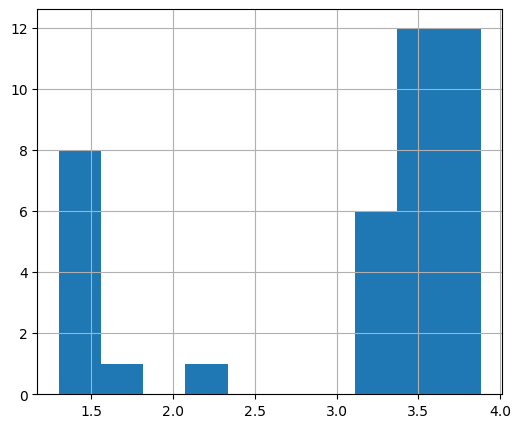

In [43]:
plt.figure(figsize=(6, 5))

train_y.hist()

Now we can train a model with the cross-validated parameters, using our full training dataset.

In [44]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=80)

Measuring the predicted values against our test set, let's see how well the model did using just the sequence embeddings features.

In [45]:
y_pred = xg_reg.predict(xgb.DMatrix(data=test_x, label=test_y))

<AxesSubplot:xlabel='label'>

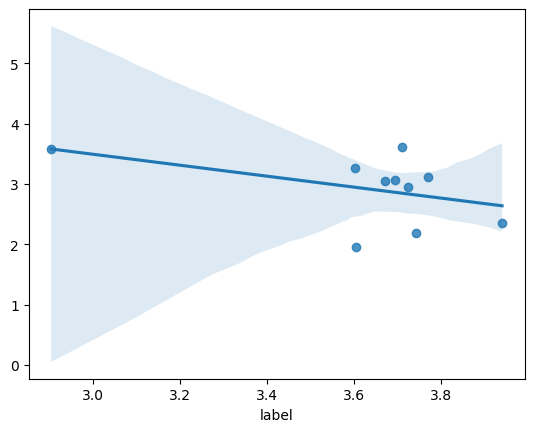

In [48]:
sns.regplot(x=test_y, y=y_pred)

Lastly, we can attempt to inspect the model and learn a bit more about it, its fit, and our data.

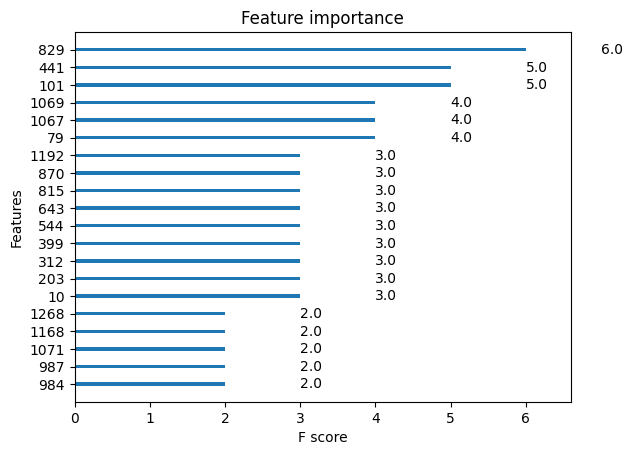

In [49]:
xgb.plot_importance(xg_reg, max_num_features=20, grid=False)
plt.rcParams['figure.figsize'] = [10, 8]
plt.show()